In [1]:
using Revise

In [2]:
using OpticalBlochEquations

┌ Info: Precompiling OpticalBlochEquations [691d0331-80d3-41b1-b293-7891a6f4a14f]
└ @ Base loading.jl:1423


In [3]:
using Plots
using BenchmarkTools
using DifferentialEquations

In [4]:
const λ = @with_unit 626 "nm"
const Γ = @with_unit 2π * 8 "MHz"
const M = @with_unit 50 "u"
const E₀ = c / λ
;

In [5]:
# Wigner D-matrix to rotate polarization vector
D(cosβ, sinβ, α, γ) = [
    (1/2)*(1 + cosβ)*exp(-im*(α + γ)) -(1/√2)*sinβ*exp(-im*α) (1/2)*(1 - cosβ)*exp(-im*(α - γ));
    (1/√2)*sinβ*exp(-im*γ) cosβ -(1/√2)*sinβ*exp(im*γ);
    (1/2)*(1 - cosβ)*exp(im*(α - γ)) (1/√2)*sinβ*exp(im*α) (1/2)*(1 + cosβ)*exp(im*(α + γ))
];

function rotate_pol(pol, k)
    # Rotates polarization `pol` onto the quantization axis `k`
    cosβ = k[3]
    sinβ = sqrt(1 - cosβ^2)
    α = 0.0
    if abs(cosβ) < 1
        γ = atan(k[2], k[1])
    else
        γ = 0.0
    end
    return inv(D(cosβ, sinβ, α, γ)) * pol
end;

In [6]:
# Generate states
m1 = manifold(F=1, ω=0, μ=0)
m2 = manifold(F=2, ω=E₀, μ=0, Γ=Γ)
states = [m1.states..., m2.states...]

δ = -2.5Γ
s = 2.0

# Generate lasers
x = [1., 0, 0]
y = [0., 1, 0]
z = [0., 0, 1]

σ_m = [1., 0., 0.]
σ_p = [0., 0., 1.]

l1 = Laser(-x, rotate_pol(σ_m, -x), E₀ + δ, s)
l2 = Laser( x, rotate_pol(σ_p,  x), E₀ + δ, s)

l3 = Laser(-y, rotate_pol(σ_m, -y), E₀ + δ, s)
l4 = Laser( y, rotate_pol(σ_p,  y), E₀ + δ, s)

l5 = Laser(-z, rotate_pol(σ_m, -z), E₀ + δ, s)
l6 = Laser( z, rotate_pol(σ_p,  z), E₀ + δ, s)

lasers = [l1, l2, l3, l4, l5, l6]

d = zeros(8, 8, 3)
d_1 = [
    0.0 0.0 0.40824829 0.0 0.0;
    0.0 0.0 0.0 0.70710678 0.0;
    0.0 0.0 0.0 0.0 1.0
]
d_2 = [
    0.0 -0.70710678 0.0 0.0 0.0;
    0.0 0.0 -0.81649658 0.0 0.0;
    0.0 0.0 0.0 -0.70710678 0.0
]
d_3 = [
    1.0 0.0 0.0 0.0 0.0;
    0.0 0.70710678 0.0 0.0 0.0;
    0.0 0.0 0.40824829 0.0 0.0
]

d[1:3,4:8,1] = d_1
d[4:8,1:3,1] = d_1'
d[1:3,4:8,2] = d_2
d[4:8,1:3,2] = d_2'
d[1:3,4:8,3] = d_3
d[4:8,1:3,3] = d_3'
;

In [7]:
freq_res = 1e-4

0.0001

In [8]:
t_end = 2π * 100
tspan = (0., t_end)
times = range(tspan[1], tspan[2], 5000)
;

In [13]:
ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[2,2] = 1

(dρ, ρ, p) = obe(states, lasers, d, ρ0, freq_res=freq_res)
;

In [15]:
@btime ρ!($dρ, $ρ, $p, $1.0)

  1.380 μs (0 allocations: 0 bytes)


In [29]:
using StaticArrays

p.particle.r0 = SVector(0.0, 0.0, 0.1)
p.particle.v = SVector(0.1, 0.0, 1.0)
prob = ODEProblem(ρ!, ρ0, tspan, p, callback=AutoAbstol(false, init_curmax=0.0))

#v_rounded = round_vel(0.0, λ, Γ, freq_res)

@time sol = solve(prob, alg=DP5(), abstol=1e-8, reltol=1e-6, dense=false, saveat=times)
length(sol.t)

  0.029127 seconds (7.28 k allocations: 6.666 MiB)


5000

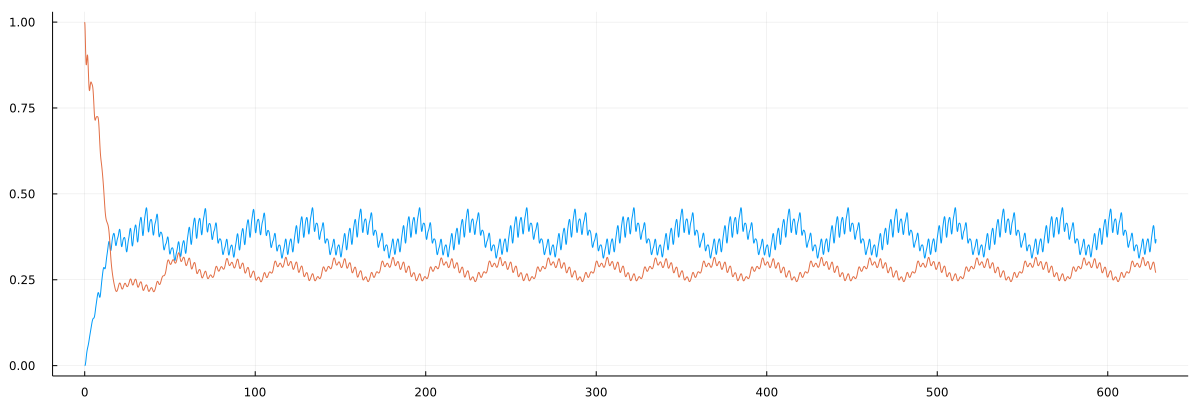

In [30]:
plot(sol.t, [real(u[1,1]) for u in sol.u], size=(1200, 400))
plot!(sol.t, [real(u[2,2]) for u in sol.u], legend=false)

In [31]:
real.(mean(sol.u[end-3000:end]))

8×8 Matrix{Float64}:
  0.379563     0.00911031  -0.00305522  …   1.726e-5      8.45853e-6
  0.00911031   0.279176     0.00889634      4.83958e-6    1.4019e-5
 -0.00305522   0.00889634   0.25408         1.05262e-6   -4.11197e-6
  8.98517e-5   1.72834e-5  -5.77353e-6     -0.000105288  -4.42924e-5
 -1.42688e-5   6.06976e-5  -2.92591e-5      0.0018923     0.000137135
 -4.28113e-5  -2.84793e-5   3.54817e-5  …  -0.00482827    0.00119042
  1.726e-5     4.83958e-6   1.05262e-6      0.00626671   -0.00410288
  8.45853e-6   1.4019e-5   -4.11197e-6     -0.00410288    0.00443789

In [32]:
function chunk_time(v, t_max, deltat_v)
    chunk_time = 0.0
    if iszero(v)
        chunk_time = t_max
    else
        chunk_time = minimum((2π * deltat_v / abs(v), t_max))
    end
    return chunk_time
end

chunk_time (generic function with 1 method)

In [33]:
function calculate_force(p, sol)
    force = 0.0
    for i in 1:length(sol.t)
        force += OpticalBlochEquations.force(p, sol.u[i], sol.t[i])
    end
    return force / length(sol.t)
end

calculate_force (generic function with 1 method)

In [34]:
function calculate_force_dense(times, p, sol)
    force = 0.0
    for t in times
#         force += real(sol.u[i][1,1]) / 5000
        force += OpticalBlochEquations.force(p, sol(t), t)
    end
#     return mean(real(u[2,2]) for u in sol.u)
    return force / length(sol.t)
end

calculate_force_dense (generic function with 1 method)

In [35]:
t_max = 2π * 3000
max_iters = 10
reltol = 1e-3
;

In [62]:
vs = 0:0.2:7.0
# rounded_vs = [round_vel(v, λ, Γ, freq_res) for v in vs]
forces = zeros(length(vs))

@time begin
#     Threads.@threads for i in 1:length(vs)
    for i in 1:length(vs)
        
        v = vs[i]
        
        delta_t = chunk_time(v, t_max, 30)
#         println(delta_t)
        
        previous_force = 0.0
        force = 1.0
        error = 1.0
        
        p_ = deepcopy(p)
        
        p_.particle.r = SVector(0.1, 0.1, 0.1)
        p_.particle.v = SVector(v, 0.0, 0.1)
         
        ρ0 = zeros(ComplexF64,(8,8))
        ρ0[1,1] = 0.5
        ρ0[2,2] = 0.5
        
        j = 0
        
        while (error > reltol) && (j < max_iters)
               
            tspan = (delta_t * j, delta_t * (j + 1))
            times = range(tspan[1], tspan[2], 5000)

            prob = ODEProblem(ρ!, ρ0, tspan, p_)
#             sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-3, save_everystep=true)
            sol = solve(prob, alg=DP5(), abstol=1e-6, reltol=1e-3, saveat=times)
#             sol = solve(prob, alg=OwrenZen5(), abstol=1e-6, reltol=1e-3, dense=true)
            
            previous_force = force
            force = calculate_force(p_, sol)
#             force = calculate_force_dense(times, p_, sol)
            
            j += 1
            error = ((previous_force - force) / force)^2
            
        end

#         println(v, real.(sol.u[end]))
#         println(error, ' ', j)
        forces[i] = force
            
    end
end

  4.167974 seconds (1.03 M allocations: 1.001 GiB, 2.46% gc time)


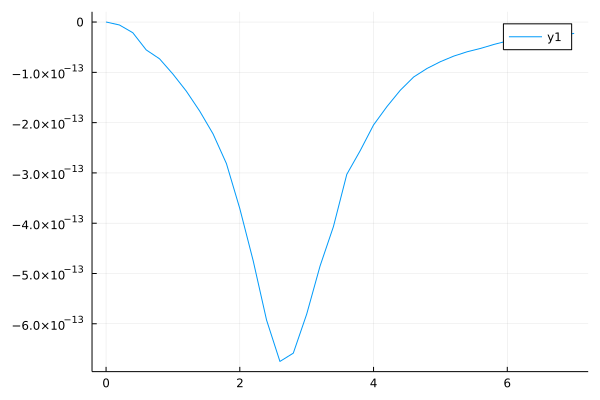

In [63]:
plot(vs, real.(forces), size=(600,400))